In [1]:
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import tqdm
import numpy as np

with open("./train.pkl", "rb") as f:
    train = pickle.load(f) # a dictionary

with open("./validation.pkl", "rb") as f:
    val = pickle.load(f) # a dictionary
    
with open("./test.pkl", "rb") as f:
    test = pickle.load(f) # a dictionary

In [2]:
# show the size of the train, val, test
print("Train dataset size", len(train['images']))
print("Validation dataset size", len(val['images']))
print("Test dataset size", len(test['qry_images']))

Train dataset size 38400
Validation dataset size 9600
Test dataset size 600


In [3]:
# numpy comcatenate from train and val
new_train = {}
new_train['images'] = np.concatenate((train['images'], val['images']), axis=0)
new_train['labels'] = np.concatenate((train['labels'], val['labels']), axis=0)
print("New train dataset size", len(new_train['images']))
print("New train dataset shape", new_train['images'].shape)

New train dataset size 48000
New train dataset shape (48000, 3, 84, 84)


In [4]:
print("New train label size", len(new_train['labels']))
print("New train label shape", new_train['labels'].shape[0])

New train label size 48000
New train label shape 48000


In [5]:
# traversal all new_train['labels'] and calculate the number of each class
class_num = {}
for i in range(new_train['labels'].shape[0]):
    if new_train['labels'][i] in class_num:
        class_num[new_train['labels'][i]] += 1
    else:
        class_num[new_train['labels'][i]] = 1
print("Class number", len(class_num))
print("Class number", class_num)

Class number 64
Class number {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200, 5: 1200, 6: 1200, 7: 1200, 8: 1200, 9: 1200, 10: 1200, 11: 1200, 12: 1200, 13: 1200, 14: 1200, 15: 1200, 16: 600, 17: 600, 18: 600, 19: 600, 20: 600, 21: 600, 22: 600, 23: 600, 24: 600, 25: 600, 26: 600, 27: 600, 28: 600, 29: 600, 30: 600, 31: 600, 32: 600, 33: 600, 34: 600, 35: 600, 36: 600, 37: 600, 38: 600, 39: 600, 40: 600, 41: 600, 42: 600, 43: 600, 44: 600, 45: 600, 46: 600, 47: 600, 48: 600, 49: 600, 50: 600, 51: 600, 52: 600, 53: 600, 54: 600, 55: 600, 56: 600, 57: 600, 58: 600, 59: 600, 60: 600, 61: 600, 62: 600, 63: 600}


In [ ]:
# transform = torchvision.transforms.ToPILImage()
# img2 = transform(torch.tensor(new_train["images"][38400])*255)
# img2

In [15]:
print(type(new_train['images']))

<class 'numpy.ndarray'>


In [46]:
# data augmentation for train

# set device as gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

train_transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize((0.5,), (0.5,))])

val_transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),
        transforms.Normalize((0.5,), (0.5,))])

class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, images, labels, transform=None):
                # load data from numpy array
                self.images = torch.from_numpy(images) # transform from numpy to tensor
                self.labels = labels # transform from numpy to tensor, but it is not necessary, since the label is a number
                self.transform = transform
                
        def __len__(self):
                return len(self.images)
        
        def __getitem__(self, idx):
                image = self.images[idx]
                label = self.labels[idx]
                if self.transform:
                        image = self.transform(image)
                return image, label

# doing data augmentation for train["images"]
train_dataset = CustomDataset(new_train["images"], new_train["labels"], transform=train_transform)
val_dataset = CustomDataset(val["images"], val["labels"], transform=val_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=8)

cuda:0


In [42]:
# show the size of the train_loader
print("Train loader size", len(train_loader))
print("Validation loader size", len(val_loader))

Train loader size 750
Validation loader size 150


In [48]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None: # identity mapping used
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)
        return x
    
class ResNet18(torch.nn.Module):
    def __init__(self, num_classes=80):
        super(ResNet18, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2) 
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, block_num, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride=stride))
        for i in range(1, block_num):
            layers.append(ResNetBlock(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

In [47]:
# train the model with train_loader and test the model with val_loader

model = ResNet18().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1280, gamma=0.8) # step_size: how many epochs to decay the learning rate by gamma

In [53]:
# train the model
train_epoch = 100
train_acc = []
train_loss = []
val_acc = []
val_loss = []
batch_size = 128

for epoch in range(train_epoch):
    train_loss_sum = 0
    train_acc_sum = 0
    
    model.train()
    train_loop = tqdm.tqdm((train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, target) in enumerate(train_loop):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_acc_sum += (predicted == target.to(device)).sum().item()
        train_loop.set_description(f'Training, Epoch [{epoch + 1}/{train_epoch}]')
        train_loop.set_postfix(loss=train_loss_sum / ((batch_idx + 1) * batch_size), acc=train_acc_sum / ((batch_idx + 1) * batch_size), lr=optimizer.param_groups[0]['lr'])

    model.eval()
    val_loss_sum = 0
    val_acc_sum = 0
    test_loop = tqdm.tqdm((val_loader), total=len(val_loader), leave=False)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loop):
            output = model(data.to(device))
            loss = criterion(output, target.to(device))
            val_loss_sum += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_acc_sum += (predicted == target.to(device)).sum().item()
            test_loop.set_description(f'Testing, Epoch [{epoch + 1}/{train_epoch}]')
            test_loop.set_postfix(loss=val_loss_sum / ((batch_idx + 1) * batch_size), acc=val_acc_sum / ((batch_idx + 1) * batch_size), lr=optimizer.param_groups[0]['lr'])

        val_acc.append(val_acc_sum / len(val_loader.dataset))
        val_loss.append(val_loss_sum / len(val_loader.dataset))

Testing, Epoch [9/100]:  16%|█▌        | 24/150 [00:42<00:24,  5.19it/s, acc=0.271, loss=0.0124, lr=0.001]  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa56c9ae820>
Traceback (most recent call last):
  File "/home/mllab/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/mllab/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/mllab/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Testing, Epoch [9/100]:  52%|█████▏    | 78/150 [00:46<00:04, 14.76it/s, acc=0.275, loss=0.0122, lr=0.001]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa56c9ae820>
Traceback (most recent call last):
  File "/home/mllab/anaconda3/lib

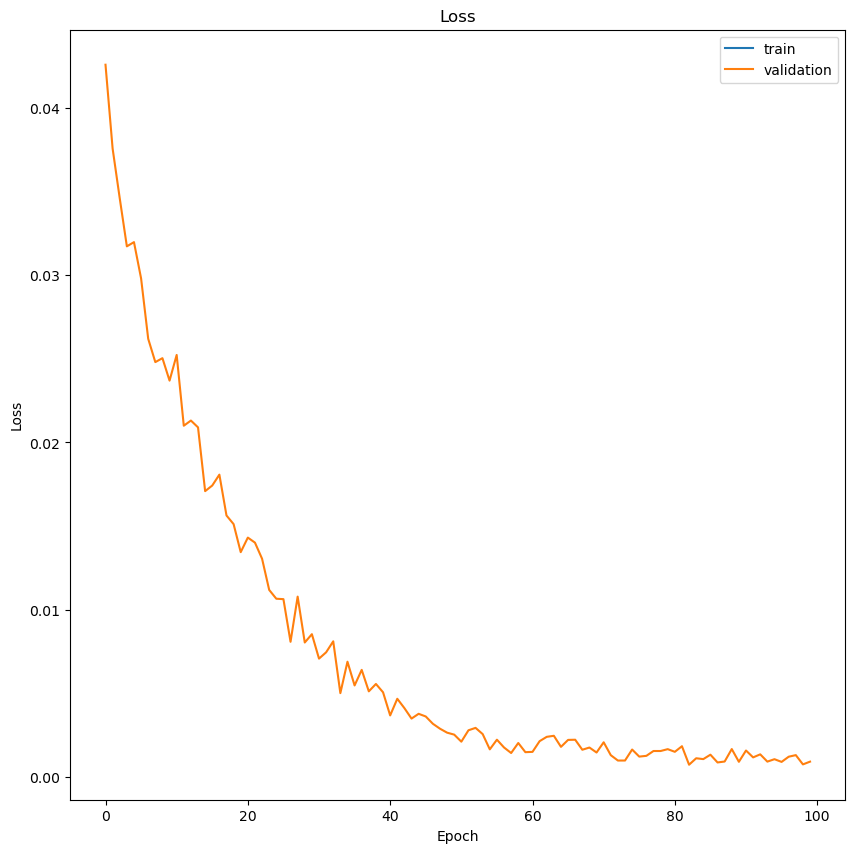

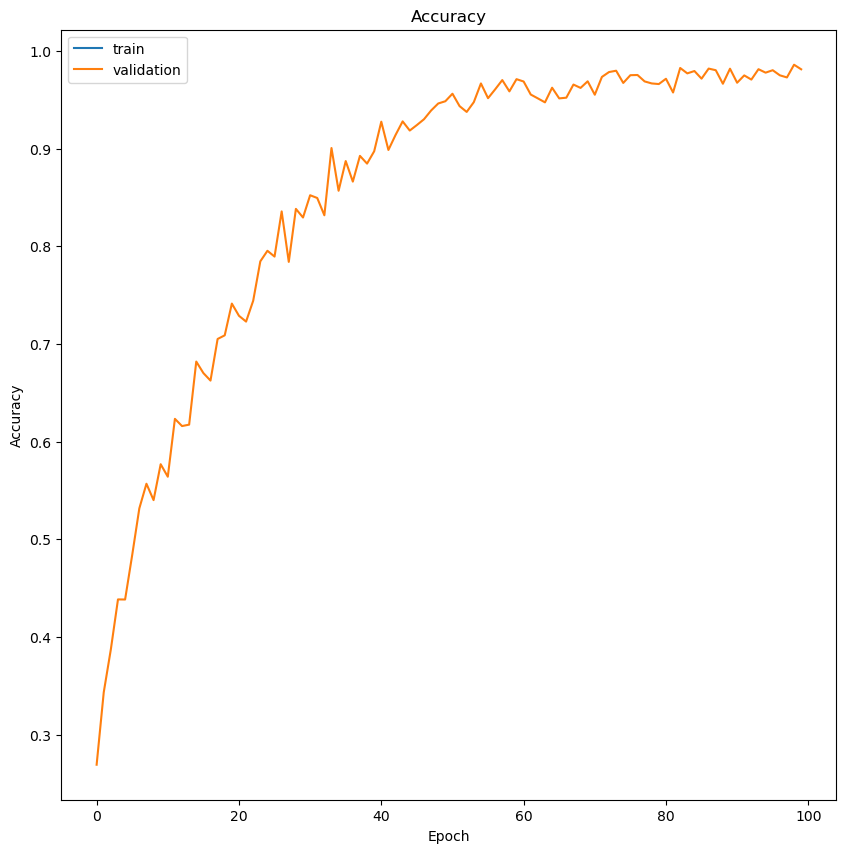

In [55]:
import matplotlib.pyplot as plt

# plot the loss and accuracy
plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()